# Challenge 2: Multi-class Image Classification
Students: <br>
Abdelrahman Habib <br>
Luisana Álvarez Monsalve

Table of contents:
1. Imports
2. Classes and functions
3. Preprocessing images
4. Feature extraction
5. Loading the data for classification with machine learning
6. Experimenting with different approaches for class balancing and feature selection and different classifiers
    6.1 Oversampling with SMOTE, undersampling with RandomUndersampler + SelectKBest for feature selection
    6.2 Oversampling with SMOTE, undersampling with RandomUndersampler + Recursive Feature Elimination for feature selection
    6.3 Undersampling with TomekLinks, oversampling with ADASYN, SelectKBest for feature selection
7. Retraining the best model with all the data and predicting on the testing set
    

#### 1. Imports

In [1]:
# To hide deprication warnings 
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Append helpers module to use the implemented modules from there
import sys
sys.path.append('../helpers/')

from pathlib import Path
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import natsort
import cv2
import csv
import random
import pprint
import seaborn as sns
import subprocess
import cmath

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, cohen_kappa_score, multilabel_confusion_matrix, balanced_accuracy_score, confusion_matrix, roc_auc_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE

from scipy.stats import mode, skew, kurtosis, entropy
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern

from sklearn.feature_selection import SelectKBest, RFE

# PPrint object
pp = pprint.PrettyPrinter(indent=4)

try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected')
    gpu = True
except Exception: # this command not being found can raise quite a few different errors depending on the configuration
    print('No Nvidia GPU in system')
    gpu = False

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

Nvidia GPU detected


#### 2. Classes and functions

In [2]:
class Preprocessing:
    def __init__(self) -> None:
        pass

    def resize_images(self, image, new_size=(227, 227), preserve_ratio = False):
        '''Resizing function to handle image sizes from different datasets. It can resize to a fixed 
        ratio, or preserve the ratio as HAM10000 dataset aspect ratio.
        '''
        height, width       = image.shape[:2]

        # print(f"i/p image shape (h, w, c): {image.shape}")

        # Option to preserve the ratio of all images, so resizing all images' longer 
        # side to 600 pixels while preserving the aspect ratio.
        if(preserve_ratio):
            # if HAM10000, don't resize
            if (height, width) == (450, 600):
                return image        
            
            # HAM10000 aspect ratio is 600 / 450 = 1.33333333 
            image_aspect_ratio = float(600) / 450

            # print(f"Resizing as HAM10000 ratio with the longest side = 600 : {image_aspect_ratio}")

            if width > height:
                new_width = 600
                new_height = int(new_width / image_aspect_ratio)
            else:
                new_height = 600
                new_width = int(new_height * image_aspect_ratio)

            resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

        else:
            # For consistency, all the images are resized to 227×227×3.
            resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)

        return resized_image

    def extract_hair(self, img):
        '''
        Function for extracting the hair from the images.
        '''
        # Convert RGB to grayscale
        img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply CLAHE for contrast enhancement of the grayscale image
        clip_limit = 1.0 
        tile_size = 10 
        CLAHE = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_size,tile_size))
        img_CLAHE = CLAHE.apply(img_grayscale)

        # Apply Gaussian filter
        filter_size = 5
        filtered_image = cv2.GaussianBlur(img_CLAHE, (filter_size, filter_size), 0)

        # Canny edge detection
        # Calculate the median pixel value of the image
        median_value = np.median(filtered_image)
        # Define high and low thresholds for Canny
        high_threshold = median_value + 75
        low_threshold = median_value - 75
        # Apply Canny edge detection with the selected thresholds
        edges = cv2.Canny(filtered_image, low_threshold, high_threshold)

        # Dilation
        # Define the size of the dilation kernel (structuring element)
        kernel_size = (9, 9)  # Adjust the size as needed
        # Perform dilation
        dilated_image = cv2.dilate(edges, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size))

        # Inpainting the unwanted regions (hair binary mask) 
        inpainted_img = cv2.inpaint(img, dilated_image, inpaintRadius=5, flags=cv2.INPAINT_TELEA) # INPAINT_NS

        return inpainted_img  
      
    def crop_frame(self, image, threshold = 0.2, debug=False, margin=0.31):
        # Convert the image to grayscale
        gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
            
        # Gaussian blur and binarize
        blurred = cv2.GaussianBlur(gray, (0, 0), 2)
        _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Find connected components and their properties
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Cropping flag for identifying cropped images
        CROP_FLAG = False

        if contours:        
            # Calculate the center and diameter of the largest component
            largest_contour = max(contours, key=cv2.contourArea)

            # finds a circle of the minimum area enclosing an area
            (x , y), radius = cv2.minEnclosingCircle(largest_contour) # returns the center and radius

            # casting from float to int for precision, necessary for visualizing 
            center = (int(x), int(y)) #(x, y)
            radius = int(radius)

            if debug:
                # for debugging we can visualize the contour of the minimum enclosing circle using its radius
                print(center, radius)
                cv2.circle(image, center, 5, (255, 0, 0), -1)   # viz the center as a dot (small radius)
                cv2.circle(image, center, radius, (255,0,0), 3) # viz the center as a crcle
            
            # Define the cropping box
            x_min = int(center[0] - radius)
            x_max = int(center[0] + radius)
            y_min = int(center[1] - radius)
            y_max = int(center[1] + radius)

            # check if we need to crop the images based on their intensities mean
            cropped_image = image.copy()[y_min:y_max, x_min:x_max]

            # Calculate mean values inside and outside the cropping box
            mean_inside = np.mean(cropped_image)

            # Calculate mean values outside the cropping box
            mean_above = np.mean(image[:y_min, :])
            mean_below = np.mean(image[y_max:, :])
            mean_left = np.mean(image[y_min:y_max, :x_min])
            mean_right = np.mean(image[y_min:y_max, x_max:])

            # Calculate mean_outside as the average of the four regions
            mean_outside = (mean_above + mean_below + mean_left + mean_right) / 4

            if mean_outside / mean_inside < threshold:
                # Define the cropping box with the required margin (TO EXCLUDE THE MARGIN FROM AFFECTING THIS VALIDATION)
                ret =  image.copy()[
                    int(center[1] - radius + margin * radius):int(center[1] + radius - margin * radius), 
                    int(center[0] - radius + margin * radius):int(center[0] + radius - margin * radius)]
                CROP_FLAG = True
            else: 
                # print("Doesn't required cropping")
                ret = image
        else:
            # print("No contours found, doesn't required cropping")
            ret = image

        return ret, CROP_FLAG

In [3]:
class FeatureExtraction:
    def __init__(self) -> None:
        pass

    def _plot_histogram(self, hist, title='Histogram'):
        # Determine the number of bins based on the length of the histogram
        num_bins = len(hist)

        # Create an array of bin edges
        bin_edges = np.arange(num_bins)

        # Create a bar plot for the histogram
        plt.bar(bin_edges, hist)

        # Set labels and a title
        plt.xlabel('Bin')
        plt.ylabel('Frequency')
        plt.title(title)

        # Show the plot
        plt.show()

    def calculate_hist_features(self, hist):
        '''
        Calculates feature from the provided histogram
        '''
        feature_vector = []
        
        feature_vector.append(np.dot([i for i in range(0,256)], hist)) # Mean
        feature_vector.append(np.argmax(hist)) # Mode
        feature_vector.append(np.std(hist)) # Standard deviation
        feature_vector.append(skew(hist)) # Skewness
        feature_vector.append(np.sum(hist**2)) # Energy
        feature_vector.append(entropy(hist, base=2)) # Entropy
        feature_vector.append(kurtosis(hist)) # Kurtosis

        return np.array(feature_vector)
    
    def _compute_norm_hist(self, image, bins=256, range=(0, 256), gray=False, density=True):
        if not gray:
            hist_ch1, _ = np.histogram(image[:, :, 0], bins, range, density)
            hist_ch2, _ = np.histogram(image[:, :, 1], bins, range, density)
            hist_ch3, _ = np.histogram(image[:, :, 2], bins, range, density)

            return hist_ch1, hist_ch2, hist_ch3
        else:
            hist_gray, _ = np.histogram(image, bins, range, density)
            # hist_gray = hist_gray / np.sum(hist_gray)

            return hist_gray
    
    def extract_color_features(self, img):
        '''
        Extracts color features in different color spaces.
        '''
        # BGR
        hist_b, hist_g, hist_r = self._compute_norm_hist(img)

        # HSV
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hist_h, hist_s, hist_v = self._compute_norm_hist(hsv_img)

        # LAB
        lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        hist_L, hist_A, hist_B = self._compute_norm_hist(lab_img)

        # Gray
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hist_gray = self._compute_norm_hist(gray_img, gray=True)

        # Concatenate all features in an array
        color_features = np.concatenate((
            self.calculate_hist_features(hist_r), 
            self.calculate_hist_features(hist_g), 
            self.calculate_hist_features(hist_b),
            
            self.calculate_hist_features(hist_h), 
            self.calculate_hist_features(hist_s), 
            self.calculate_hist_features(hist_v),

            self.calculate_hist_features(hist_L),
            self.calculate_hist_features(hist_A),
            self.calculate_hist_features(hist_B),

            self.calculate_hist_features(hist_gray),
            )
        )

        return color_features
    
    def extract_glcm_features(self, image):    
        if not isinstance(image, np.ndarray):
            raise ValueError("Input must be a numpy array")

        if image.dtype != np.uint8:
            # If the image is not 8-bit, convert it to 8-bit
            # important as we set the levels for glcm to 256 for 8-bit images
            image = image.astype(np.uint8)

        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Compute GLCM matrix
        distances = [1]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        glcm = graycomatrix(gray_image, distances, angles, levels=256, symmetric=True, normed=True)
        
        # Extract texture features from GLCM matrix
        features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
        texture_features = np.concatenate([graycoprops(glcm, feature).ravel() for feature in features])
        
        return texture_features
    
    def extract_lbp_features(self, image):
        ''' 
        Extracts the histogram of the LBP image for a certain number of neighbours and radius.

        Args:
            image (numpy.ndarray): the image from which the LBP features will be extracted (cropped ROI)
            P (int): number of neighbours
            R (int): radius
        Output:
            hist (numpy.array): histogram of the LBP image
        '''

        P=[8, 16] 
        R=[1, 2]
        histogram = []

        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        for idx, P_value in enumerate(P):

            n_points = P_value * R[idx]

            lbp_image = local_binary_pattern(gray_image, n_points, R[idx], method='uniform')

            # Calculate the histogram of the LBP image
            hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2), density=True)

            # Normalize the histogram
            hist /= np.sum(hist)

            histogram = np.concatenate((histogram, hist))
        
        return histogram
    
    def region_based_hist_fe(self, callback_func, image):
        # We split the image into 3 parts, each is 1/3 of the original height
        height, _, _ = image.shape
        partial_height = height // 3

        # Sotring the images into a list to iterate through them and get the feature vector for each part separately
        images_list = [
            image[0:partial_height, :],
            image[partial_height:2*partial_height, :],
            image[2*partial_height:, :],
        ]

        feature_vector = []

        for img in images_list:
            partial_feature_vector = callback_func(img)
            feature_vector = np.concatenate((feature_vector, partial_feature_vector))

        return feature_vector

    def fit(self, image):
        # color_features      = self.extract_color_features(image)
        color_features      = self.region_based_hist_fe(
            callback_func=self.extract_color_features,
            image=image
        )
        texture_features    = self.extract_glcm_features(image)
        lbp_features        = self.extract_lbp_features(image)
        # hog_features        = self.extract_hog_features(image) # 1 file of 7k samples ended up 24GB size

        all_features = np.concatenate((color_features, texture_features, lbp_features))

        return all_features

In [4]:
class FeatureSelection:
    def __init__(self) -> None:
        pass

    def calc_n_features(self, n_samples):
        '''
            Calculates the number of features to keep after selection (D) from the number of samples (N)
            Thumb rule = N >= D(D-1)/2
        '''
        a = 1
        b = -1
        c = -2 * n_samples

        # calculate the discriminant
        d = (b**2) - (4*a*c)

        # find two solutions
        sol1 = (-b-cmath.sqrt(d))/(2*a)
        sol2 = (-b+cmath.sqrt(d))/(2*a)

        n_features = int(np.max([np.round(np.abs(sol1)), np.round(np.abs(sol2))]))

        return n_features


    def select_bestk_features(self, data, target):

        # Get the best value of k from grid search
        best_k = self.calc_n_features(data.shape[0])

        # Apply Maximum Entropy-based feature selection with the best k
        selector = SelectKBest(k=best_k) # score_func=mutual_info_classif
        X_new = selector.fit_transform(data, target)

        # Get the indices of the selected features
        selected_features = np.where(selector.get_support())[0]

        # Convert X_new to a DataFrame with selected features
        selected_data = pd.DataFrame(X_new, columns=selected_features)

        return selected_data, selected_features
    
    def select_rfe_features(self, data, target):
        # estimator_svm = SVC(kernel='linear', decision_function_shape='ovr',class_weight='balanced')
        estimater_rfe = RandomForestClassifier(n_estimators=200, max_depth= 9, min_samples_leaf=1, min_samples_split=2 ,class_weight='balanced')

        rfe = RFE(estimater_rfe, n_features_to_select=self.calc_n_features(data.shape[0]), verbose=2)
        rfe.fit(data, target)
        
        # Get the indices of the selected features
        selected_features = np.where(rfe.support_)[0]

        # Convert the data to a DataFrame with the selected features
        selected_data = pd.DataFrame(data, columns=selected_features)
        
        # selected_features = rfe.support_
        # selected_data = data[:, selected_features]

        return selected_data, selected_features


In [5]:
def pprint_objects(*arg):
    '''Prints large and indented objects clearly.'''
    pp.pprint(arg)

def model_fit_predict(model, param_grid, scoring_metric, X_train, y_train, X_val, y_val, cv=5):
    # Perform grid search with cross validation 
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, verbose=0, scoring=scoring_metric)
    grid_search.fit(X_train, y_train)

    # Save the best model and best parameters obtained in the grid search
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_      

    # Predict in the validation set using the best model
    y_pred = best_model.predict(X_val)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
    weighted_f1 = f1_score(y_val, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_val, y_pred)

    report = dict()
                
    report['model'] = best_model
    report['best_params'] = best_params
    report['accuracy'] = accuracy
    report['kappa'] = kappa
    report['balanced_accuracy'] = balanced_accuracy
    report['weighted_f1'] = weighted_f1

    # cfm for each class separately
    conf_matrix = multilabel_confusion_matrix(y_val, y_pred)
    classes = ['mel', 'bcc', 'scc']

    plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)

    for i, class_label in enumerate(classes):
        tp = conf_matrix[i, 1, 1]
        fp = conf_matrix[i, 0, 1]
        fn = conf_matrix[i, 1, 0]
        tn = conf_matrix[i, 0, 0]

        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        precision = tp / (tp + fp)
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

        binary_true_labels = np.where(np.array(y_val) == i, 1, 0)
        binary_predicted_labels = np.where(np.array(y_pred) == i, 1, 0)
        fpr, tpr, _ = roc_curve(binary_true_labels, binary_predicted_labels)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, lw=2, label=f'{class_label} (AUC = {roc_auc:.2f})')
        
        report[f'{class_label}_specificity'] = specificity
        report[f'{class_label}_sensitivity'] = sensitivity
        report[f'{class_label}_precision']  = precision
        report[f'{class_label}_f1'] = f1
        report[f'{class_label}_roc_auc'] = roc_auc
    
    # Set labels and legend
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {str(best_model).split("(")[0]}')
    plt.legend(loc='lower right')


    pprint_objects(report)

    # plotting cm, mel = 0, bcc = 1, scc = 2
    cm = confusion_matrix(y_val, y_pred)
    cm_df = pd.DataFrame(cm,
                         index=['mel', 'bcc', 'scc'],
                         columns=['mel', 'bcc', 'scc'])
    
    pprint_objects(cm)
    
    plt.subplot(1,2,2)
    sns.heatmap(cm_df, annot=True)
    plt.title(f'Confusion Matrix for {str(best_model).split("(")[0]}')
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

def model_predict(y_pred, y_val):

    accuracy = accuracy_score(y_val, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
    weighted_f1 = f1_score(y_val, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_val, y_pred)


    report = dict()
                
    report['accuracy'] = accuracy
    report['kappa'] = kappa
    report['balanced_accuracy'] = balanced_accuracy
    report['weighted_f1'] = weighted_f1

    # cfm for each class separately
    conf_matrix = multilabel_confusion_matrix(y_val, y_pred)
    classes = ['mel', 'bcc', 'scc']

    plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)

    for i, class_label in enumerate(classes):
        tp = conf_matrix[i, 1, 1]
        fp = conf_matrix[i, 0, 1]
        fn = conf_matrix[i, 1, 0]
        tn = conf_matrix[i, 0, 0]

        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        precision = tp / (tp + fp)
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

        binary_true_labels = np.where(np.array(y_val) == i, 1, 0)
        binary_predicted_labels = np.where(np.array(y_pred) == i, 1, 0)
        fpr, tpr, _ = roc_curve(binary_true_labels, binary_predicted_labels)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, lw=2, label=f'{class_label} (AUC = {roc_auc:.2f})')
        
        report[f'{class_label}_specificity'] = specificity
        report[f'{class_label}_sensitivity'] = sensitivity
        report[f'{class_label}_precision']  = precision
        report[f'{class_label}_f1'] = f1
        report[f'{class_label}_roc_auc'] = roc_auc
    
    # Set labels and legend
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve')
    plt.legend(loc='lower right')


    pprint_objects(report)

    # plotting cm, bcc = 0, mel = 1, scc = 2
    cm = confusion_matrix(y_val, y_pred)
    cm_df = pd.DataFrame(cm,
                         index=['mel', 'bcc', 'scc'],
                         columns=['mel', 'bcc', 'scc'])
    
    pprint_objects(cm)
    
    plt.subplot(1,2,2)
    sns.heatmap(cm_df, annot=True)
    plt.title(f'Confusion Matrix')
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

In [6]:
preprocessor = Preprocessing()
feature_extractor = FeatureExtraction()
select_feature = FeatureSelection()

#### 3. Preprocessing images

In [11]:
ROOT_PATH = Path(Path(os.getcwd())/"../challenge2")
TRAIN_PATH = ROOT_PATH/"train"
VAL_PATH = ROOT_PATH/"val"

train_bcc = sorted(glob(str(TRAIN_PATH/'bcc/*')))
train_mel = sorted(glob(str(TRAIN_PATH/'mel/*')))
train_scc = sorted(glob(str(TRAIN_PATH/'scc/*')))

val_bcc = sorted(glob(str(VAL_PATH/'bcc/*')))
val_mel = sorted(glob(str(VAL_PATH/'mel/*')))
val_scc = sorted(glob(str(VAL_PATH/'scc/*')))

# Pre-processing and feature extraction
prep_imgs_dir = r'../output/'

bcc_train_prep_filename    = 'bcc_train_prep_images.pkl'
bcc_val_prep_filename      = 'bcc_val_prep_images.pkl'

mel_train_prep_filename   = 'mel_train_prep_images.pkl'
mel_val_prep_filename     = 'mel_val_prep_images.pkl'

scc_train_prep_filename   = 'scc_train_prep_images.pkl'
scc_val_prep_filename     = 'scc_val_prep_images.pkl'


filenames_prep_list = [bcc_train_prep_filename, bcc_val_prep_filename, mel_train_prep_filename,  mel_val_prep_filename, scc_train_prep_filename, scc_val_prep_filename]
dir_list = [train_bcc, val_bcc, train_mel, val_mel, train_scc, val_scc]

subsample               = False

for index, filename in enumerate(filenames_prep_list):

    preprocessed_images = []

    for count, image_path in tqdm(enumerate(dir_list[index])):

        if subsample:
            if count == 999: # only 1k per class
                break

        # reading the image 
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)

        # 1. Copping black frame
        image_without_black_frame, _ = preprocessor.crop_frame(image)

        # 2. Resizing
        image_resized = preprocessor.resize_images(image_without_black_frame, preserve_ratio=True)

        # 3. Removing hair
        image_without_hair = preprocessor.extract_hair(image_resized)

        # Saving the preprocessed image to a list
        preprocessed_images.append(image_without_hair)

    # Saving the preprocessed images to a pickle file
    with open(prep_imgs_dir+filename, 'wb') as file:
        pickle.dump(preprocessed_images, file)

#### 4. Feature extraction

In [ ]:
# Load pickles of preprocessed images
with open(os.path.join(prep_imgs_dir, mel_train_prep_filename), 'rb') as file:
    mel_train_prep_images = pickle.load(file)
with open(os.path.join(prep_imgs_dir, mel_val_prep_filename), 'rb') as file:
    mel_val_prep_images = pickle.load(file)

with open(os.path.join(prep_imgs_dir, bcc_train_prep_filename), 'rb') as file:
    bcc_train_prep_images = pickle.load(file)
with open(os.path.join(prep_imgs_dir, bcc_val_prep_filename), 'rb') as file:
    bcc_val_prep_images = pickle.load(file)

with open(os.path.join(prep_imgs_dir, scc_train_prep_filename), 'rb') as file:
    scc_train_prep_images = pickle.load(file)
with open(os.path.join(prep_imgs_dir, scc_val_prep_filename), 'rb') as file:
    scc_val_prep_images = pickle.load(file)


features_dir = r'../output/features/'

experiment              = 3
subsample               = False

bcc_train_filename    = f'{experiment}_bcc_train_features.csv'
bcc_val_filename      = f'{experiment}_bcc_val_features.csv'

mel_train_filename    = f'{experiment}_mel_train_features.csv'
mel_val_filename      = f'{experiment}_mel_val_features.csv'

scc_train_filename   = f'{experiment}_scc_train_features.csv'
scc_val_filename     = f'{experiment}_scc_val_features.csv'

filenames_list = [bcc_train_filename, bcc_val_filename, mel_train_filename, mel_val_filename, scc_train_filename, scc_val_filename]
images_lists = [bcc_train_prep_images, bcc_val_prep_images, mel_train_prep_images, mel_val_prep_images, scc_train_prep_images, scc_val_prep_images]

labels = [1, 1, 0, 0, 2, 2] # mel = 0, bcc = 1, scc = 2


# Loop through the lists of images and their corresponding filenames
for filename, image_list, label in zip(filenames_list, images_lists, labels):
    with open(os.path.join(features_dir, filename), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)

        for count, preprocessed_image in tqdm(enumerate(image_list)):
            if subsample and count == 9:  # Only 1k per class
                break

            # 5. Extracting features
            feature_vector = feature_extractor.fit(preprocessed_image)

            # 6. Add label column
            feature_vector = np.append(feature_vector, label)

            # Write the feature vector to the CSV file
            writer.writerow(feature_vector)

#### 5. Loading the data for classification with machine learning

In [16]:
features_dir = r'../output/features/'
experiment              = 3

# Load features .csv files
train_bcc_df = pd.read_csv(os.path.join(features_dir,f'{experiment}_bcc_train_features.csv'),  header = None)
val_bcc_df = pd.read_csv(os.path.join(features_dir, f'{experiment}_bcc_val_features.csv'),  header = None)

train_mel_df = pd.read_csv(os.path.join(features_dir,f'{experiment}_mel_train_features.csv'),  header = None)
val_mel_df = pd.read_csv(os.path.join(features_dir, f'{experiment}_mel_val_features.csv'),  header = None)

train_scc_df = pd.read_csv(os.path.join(features_dir,f'{experiment}_scc_train_features.csv'),  header = None)
val_scc_df = pd.read_csv(os.path.join(features_dir, f'{experiment}_scc_val_features.csv'),  header = None)

# Concatenate the 'bcc', 'mel' and 'scc' dataframes
train_features = pd.concat([train_bcc_df, train_mel_df, train_scc_df], ignore_index=True)
val_features = pd.concat([val_bcc_df, val_mel_df, val_scc_df], ignore_index=True)

# Shuffle the dataset
train_features = train_features.sample(frac=1, random_state=42)
val_features = val_features.sample(frac=1, random_state=42)

#### 6. Experimenting with different approaches for class balancing and feature selection and different classifiers


#### 6.1 Oversampling with SMOTE, undersampling with RandomUndersampler + SelectKBest for feature selection

In [10]:
# Separate the data from the target in the train and validation sets
X_train = train_features.iloc[:,:-1]
y_train = train_features.iloc[:,-1]
X_val = val_features.iloc[:,:-1]
y_val = val_features.iloc[:,-1]

# Encoding the label column
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

# Print the distribution of the data
print(pd.DataFrame(y_train_encoded).value_counts())

0    2713
1    1993
2     376
Name: count, dtype: int64


In [11]:
# OVERSAMPLING WITH SMOTE
smote = SMOTE(sampling_strategy={0:2713,1:1993,2:1993}, random_state=0) # resample all classes but majority
X_train, y_train_encoded = smote.fit_resample(X_train, y_train_encoded)

# RANDOM UNDERSAMPLING
undersampler = RandomUnderSampler(sampling_strategy={0:2300,1:1993,2:1993}, random_state=0)
X_train, y_train_encoded = undersampler.fit_resample(X_train, y_train_encoded)

# Print the new distribution of data
print(pd.DataFrame(y_train_encoded).value_counts())

0    2300
1    1993
2    1993
Name: count, dtype: int64


In [12]:
# Standardizing the training data (mean = 0, std = 1)
scaler = StandardScaler()
X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train))
X_val_normalized = pd.DataFrame(scaler.transform(X_val))

# Feature selection selecting k best features
X_train_normalized, selected_feature_indices  = select_feature.select_bestk_features(X_train_normalized, y_train_encoded)

# Apply the same transformation to the validation set
X_val_normalized = X_val_normalized.iloc[:, selected_feature_indices]

##### SVM

(   {   'accuracy': 0.8228346456692913,
        'balanced_accuracy': 0.7512090664799409,
        'bcc_f1': 0.7992164544564153,
        'bcc_precision': 0.780114722753346,
        'bcc_roc_auc': 0.8351566889318933,
        'bcc_sensitivity': 0.8192771084337349,
        'bcc_specificity': 0.8510362694300518,
        'best_params': {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
        'kappa': 0.6854594768335263,
        'mel_f1': 0.8846737481031867,
        'mel_precision': 0.9109375,
        'mel_roc_auc': 0.8817991110579606,
        'mel_sensitivity': 0.859882005899705,
        'mel_specificity': 0.9037162162162162,
        'model': SVC(C=10, class_weight='balanced', gamma=0.01),
        'scc_f1': 0.5373134328358209,
        'scc_precision': 0.5046728971962616,
        'scc_roc_auc': 0.7647000289477495,
        'scc_sensitivity': 0.574468085106383,
        'scc_specificity': 0.9549319727891157,
        'weighted_f1': 0.8254535891494665},)
(   array([[583,  84,  11],
       [ 48, 408,  42]

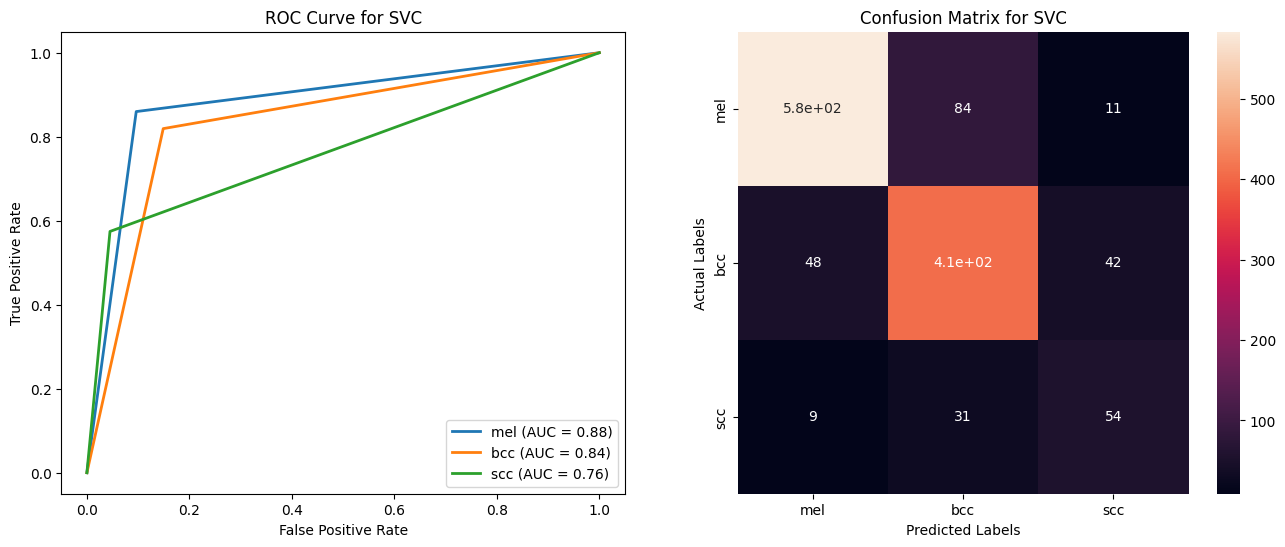

In [37]:
grid = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10], 'gamma':[0.001, 0.01, 0.1]}
model = SVC(decision_function_shape='ovr', class_weight='balanced')
model_fit_predict(model, grid, 'accuracy', X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded)

##### Random Forests

(   {   'accuracy': 0.7173228346456693,
        'balanced_accuracy': 0.6516863915840353,
        'bcc_f1': 0.6968139773895171,
        'bcc_precision': 0.7136842105263158,
        'bcc_roc_auc': 0.7522785442287284,
        'bcc_sensitivity': 0.6807228915662651,
        'bcc_specificity': 0.8238341968911918,
        'best_params': {   'max_depth': 9,
                           'min_samples_leaf': 1,
                           'min_samples_split': 2,
                           'n_estimators': 200},
        'kappa': 0.5206892201593742,
        'mel_f1': 0.8215962441314554,
        'mel_precision': 0.875,
        'mel_roc_auc': 0.8238235469983257,
        'mel_sensitivity': 0.7743362831858407,
        'mel_specificity': 0.8733108108108109,
        'model': RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=200),
        'scc_f1': 0.32525951557093424,
        'scc_precision': 0.24102564102564103,
        'scc_roc_auc': 0.6870748299319727,
        'scc_sensitivity': 0.

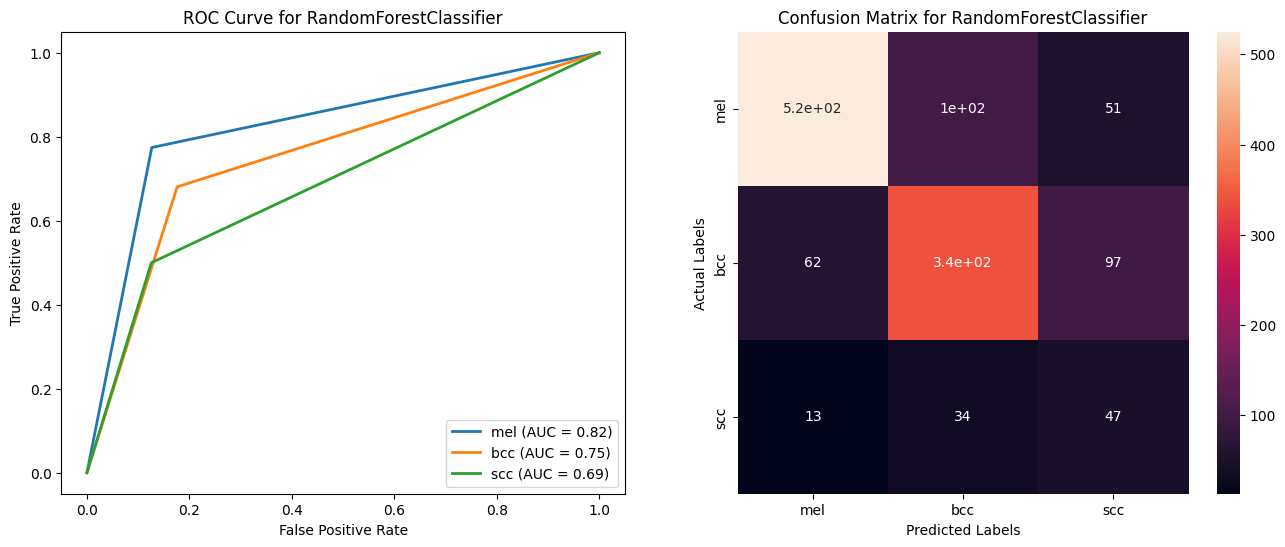

In [38]:
grid = {'n_estimators' : [50, 100, 200], 'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
model = RandomForestClassifier(class_weight='balanced')
model_fit_predict(model, grid, 'accuracy', X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded)

##### XGBoost

(   {   'accuracy': 0.7984251968503937,
        'balanced_accuracy': 0.7065233254615148,
        'bcc_f1': 0.7746341463414634,
        'bcc_precision': 0.7533206831119544,
        'bcc_roc_auc': 0.8143974863183304,
        'bcc_sensitivity': 0.7971887550200804,
        'bcc_specificity': 0.8316062176165803,
        'best_params': {   'colsample_bytree': 1.0,
                           'learning_rate': 0.1,
                           'max_depth': 5,
                           'n_estimators': 300,
                           'subsample': 0.7},
        'kappa': 0.6407910728096343,
        'mel_f1': 0.866010598031794,
        'mel_precision': 0.8895800933125972,
        'mel_roc_auc': 0.8618626923383561,
        'mel_sensitivity': 0.8436578171091446,
        'mel_specificity': 0.8800675675675675,
        'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_sto

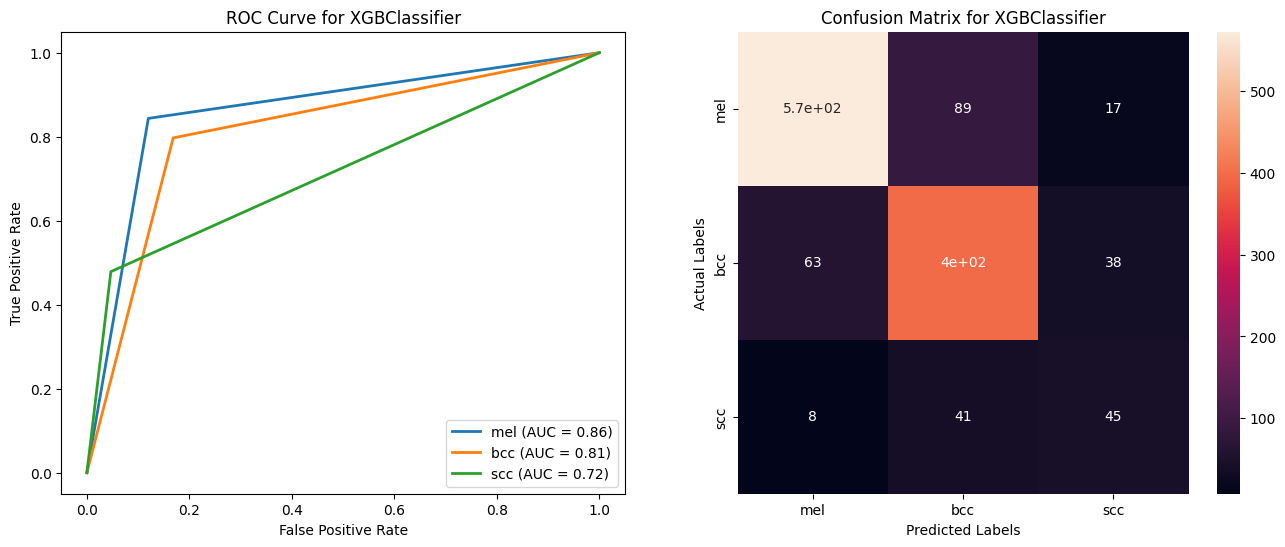

In [53]:
model = XGBClassifier({"device": "cuda:0" if gpu else "cpu"})
grid = {'max_depth': [4, 5], 'learning_rate': [0.1, 0.01], 'n_estimators': [200, 300], 'subsample': [0.5, 0.7, 1.0], 'colsample_bytree': [0.8, 0.9, 1.0]}
model_fit_predict(model, grid, 'accuracy', X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded)

##### Logistic Regression

(   {   'accuracy': 0.7,
        'balanced_accuracy': 0.6470462279671626,
        'bcc_f1': 0.6755260243632337,
        'bcc_precision': 0.7530864197530864,
        'bcc_roc_auc': 0.7414580602201553,
        'bcc_sensitivity': 0.6124497991967871,
        'bcc_specificity': 0.8704663212435233,
        'best_params': {'C': 0.1, 'penalty': None, 'solver': 'lbfgs'},
        'kappa': 0.5030400755910688,
        'mel_f1': 0.827639751552795,
        'mel_precision': 0.8737704918032787,
        'mel_roc_auc': 0.8280340628238859,
        'mel_sensitivity': 0.7861356932153393,
        'mel_specificity': 0.8699324324324325,
        'model': LogisticRegression(C=0.1, class_weight='balanced', multi_class='ovr',
                   penalty=None),
        'scc_f1': 0.2922636103151862,
        'scc_precision': 0.2,
        'scc_roc_auc': 0.6845419018671298,
        'scc_sensitivity': 0.5425531914893617,
        'scc_specificity': 0.826530612244898,
        'weighted_f1': 0.7283657409884353},)
(   array

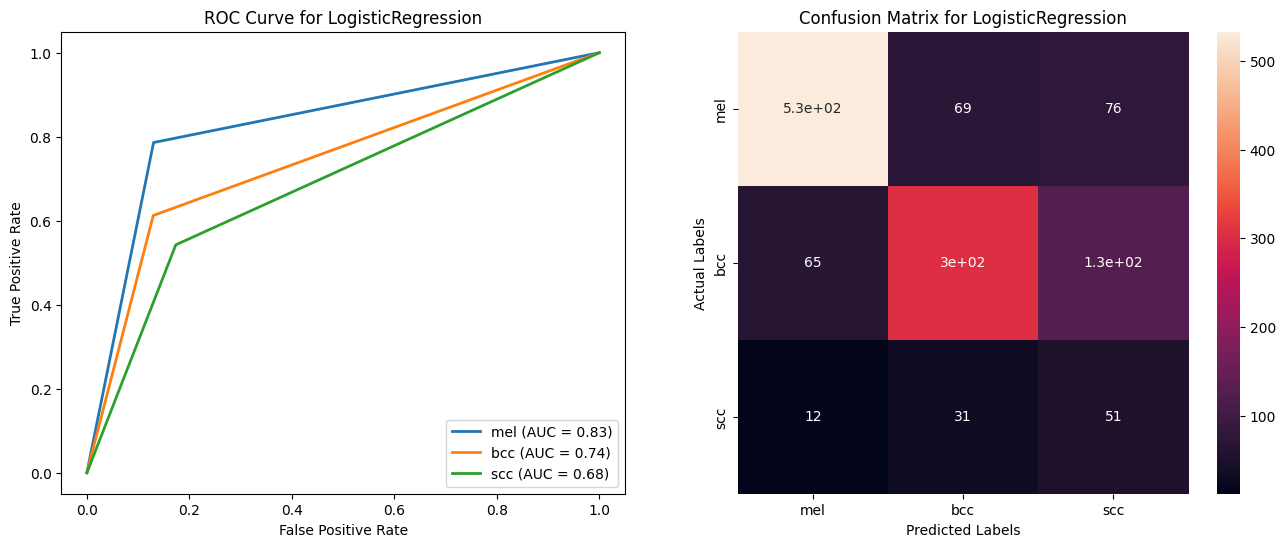

In [50]:
model = LogisticRegression(multi_class = 'ovr', class_weight='balanced')
grid = {'penalty' : ['l1', 'l2', 'elasticnet', None], 'C':[0.1, 1, 10], 'solver': ['lbfgs', 'newton-cholesky', 'sag', 'saga']}
model_fit_predict(model, grid, 'accuracy', X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded)

##### Ensemble VotingClassifier with the best models

(   {   'accuracy': 0.8291338582677166,
        'balanced_accuracy': 0.7346495125042946,
        'bcc_f1': 0.806640625,
        'bcc_precision': 0.785171102661597,
        'bcc_roc_auc': 0.8414721060407434,
        'bcc_sensitivity': 0.8293172690763052,
        'bcc_specificity': 0.8536269430051814,
        'kappa': 0.692276255728157,
        'mel_f1': 0.8863976083707025,
        'mel_precision': 0.8984848484848484,
        'mel_roc_auc': 0.8807277963804513,
        'mel_sensitivity': 0.8746312684365781,
        'mel_specificity': 0.8868243243243243,
        'scc_f1': 0.5280898876404494,
        'scc_precision': 0.5595238095238095,
        'scc_roc_auc': 0.7342687074829932,
        'scc_sensitivity': 0.5,
        'scc_specificity': 0.9685374149659864,
        'weighted_f1': 0.8286024087901878},)
(   array([[593,  75,  10],
       [ 58, 413,  27],
       [  9,  38,  47]], dtype=int64),)


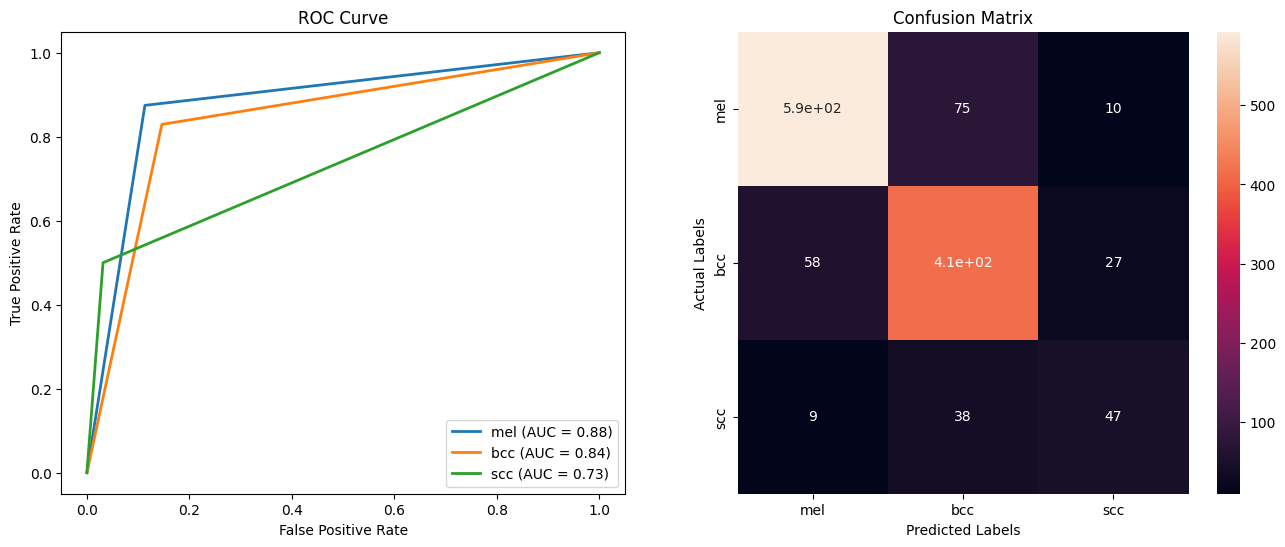

In [13]:
# Define the base classifiers
clf1 = SVC(C= 10, gamma=0.01, kernel='rbf', probability=True)  # Set probability=True for soft voting
clf2 = RandomForestClassifier(class_weight='balanced', max_depth= 9, min_samples_leaf=1, min_samples_split=2, n_estimators=200)
clf3 = XGBClassifier(colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.7)

# Create a VotingClassifier with soft voting
voting_clf = VotingClassifier(estimators=[('svc', clf1), ('rf', clf2), ('xgb', clf3)], voting='soft')

# Train the VotingClassifier on your training data
voting_clf.fit(X_train_normalized, y_train_encoded)

# Make predictions
y_pred = voting_clf.predict(X_val_normalized)

model_predict(y_pred, y_val_encoded)

#### 6.2 Oversampling with SMOTE, undersampling with RandomUndersampler + Recursive Feature Elimination for feature selection

In [17]:
# Separate the data from the target in the train and validation sets
X_train = train_features.iloc[:,:-1]
y_train = train_features.iloc[:,-1]
X_val = val_features.iloc[:,:-1]
y_val = val_features.iloc[:,-1]

# Encoding the label column
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

# Print the distribution of data
print(pd.DataFrame(y_train_encoded).value_counts())

0    2713
1    1993
2     376
Name: count, dtype: int64


In [18]:
# OVERSAMPLING WITH SMOTE
smote = SMOTE(sampling_strategy={0:2713,1:1993,2:1993}, random_state=0) 
X_train, y_train_encoded = smote.fit_resample(X_train, y_train_encoded)

# RANDOM UNDERSAMPLING
undersampler = RandomUnderSampler(sampling_strategy={0:2300,1:1993,2:1993}, random_state=0)
X_train, y_train_encoded = undersampler.fit_resample(X_train, y_train_encoded)

# Print the new distribution of data
print(pd.DataFrame(y_train_encoded).value_counts())

0    2300
1    1993
2    1993
Name: count, dtype: int64


In [19]:
# Standardizing the training data (mean = 0, std = 1)
scaler = StandardScaler()
X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train))
X_val_normalized = pd.DataFrame(scaler.transform(X_val))

# Feature selection using RFE
X_train_normalized, selected_feature_indices  = select_feature.select_rfe_features(X_train_normalized, y_train_encoded)

# Apply the same transformation to the validation set
X_val_normalized = X_val_normalized.iloc[:, selected_feature_indices]

Fitting estimator with 278 features.
Fitting estimator with 277 features.
Fitting estimator with 276 features.
Fitting estimator with 275 features.
Fitting estimator with 274 features.
Fitting estimator with 273 features.
Fitting estimator with 272 features.
Fitting estimator with 271 features.
Fitting estimator with 270 features.
Fitting estimator with 269 features.
Fitting estimator with 268 features.
Fitting estimator with 267 features.
Fitting estimator with 266 features.
Fitting estimator with 265 features.
Fitting estimator with 264 features.
Fitting estimator with 263 features.
Fitting estimator with 262 features.
Fitting estimator with 261 features.
Fitting estimator with 260 features.
Fitting estimator with 259 features.
Fitting estimator with 258 features.
Fitting estimator with 257 features.
Fitting estimator with 256 features.
Fitting estimator with 255 features.
Fitting estimator with 254 features.
Fitting estimator with 253 features.
Fitting estimator with 252 features.
F

##### SVM

(   {   'accuracy': 0.8409448818897638,
        'balanced_accuracy': 0.7824428952866634,
        'bcc_f1': 0.8257425742574257,
        'bcc_precision': 0.814453125,
        'bcc_roc_auc': 0.8571462013858543,
        'bcc_sensitivity': 0.8373493975903614,
        'bcc_specificity': 0.8769430051813472,
        'best_params': {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
        'kappa': 0.7189871531976795,
        'mel_f1': 0.8968133535660091,
        'mel_precision': 0.9234375,
        'mel_roc_auc': 0.8944555728294667,
        'mel_sensitivity': 0.8716814159292036,
        'mel_specificity': 0.9172297297297297,
        'model': SVC(C=10, class_weight='balanced', gamma=0.01),
        'scc_f1': 0.5660377358490567,
        'scc_precision': 0.5084745762711864,
        'scc_roc_auc': 0.7944890722246346,
        'scc_sensitivity': 0.6382978723404256,
        'scc_specificity': 0.9506802721088435,
        'weighted_f1': 0.8444620495021761},)
(   array([[591,  71,  16],
       [ 39, 417,  42],
  

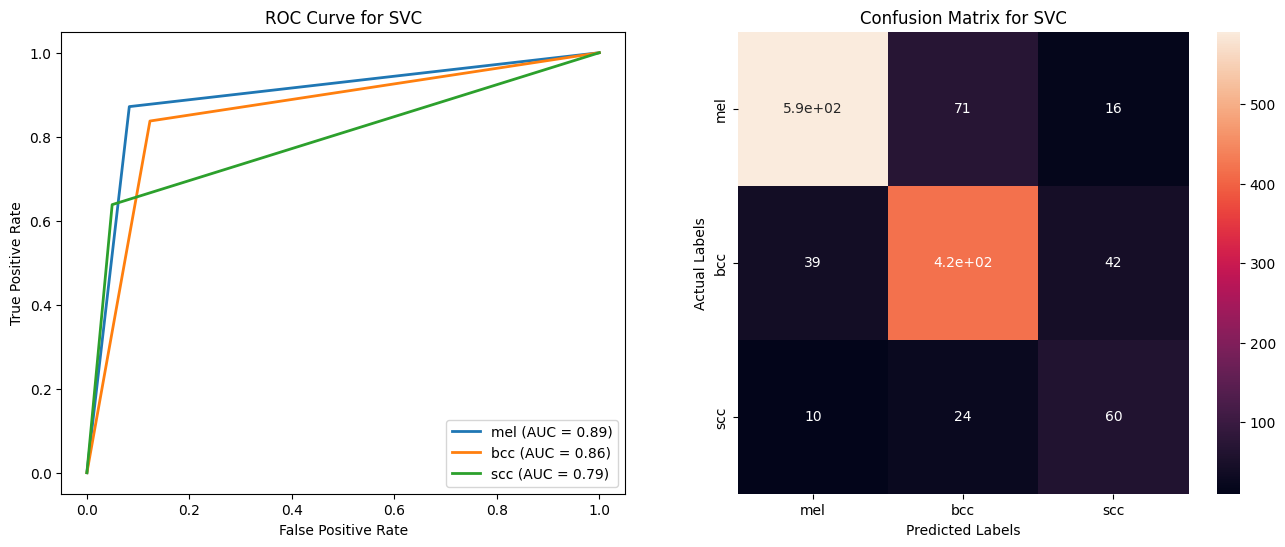

In [20]:
grid = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10], 'gamma':[0.001, 0.01, 0.1]}
model = SVC(decision_function_shape='ovr', class_weight='balanced')
model_fit_predict(model, grid, 'accuracy', X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded)

##### Random Forests

(   {   'accuracy': 0.7275590551181103,
        'balanced_accuracy': 0.664364355054058,
        'bcc_f1': 0.7039337474120082,
        'bcc_precision': 0.7264957264957265,
        'bcc_roc_auc': 0.7584639074432444,
        'bcc_sensitivity': 0.6827309236947792,
        'bcc_specificity': 0.8341968911917098,
        'best_params': {   'max_depth': 9,
                           'min_samples_leaf': 1,
                           'min_samples_split': 5,
                           'n_estimators': 200},
        'kappa': 0.5354339699240489,
        'mel_f1': 0.8281733746130031,
        'mel_precision': 0.8713355048859935,
        'mel_roc_auc': 0.827819799888384,
        'mel_sensitivity': 0.7890855457227138,
        'mel_specificity': 0.8665540540540541,
        'model': RandomForestClassifier(class_weight='balanced', max_depth=9,
                       min_samples_split=5, n_estimators=200),
        'scc_f1': 0.34751773049645396,
        'scc_precision': 0.26063829787234044,
        'scc_roc_

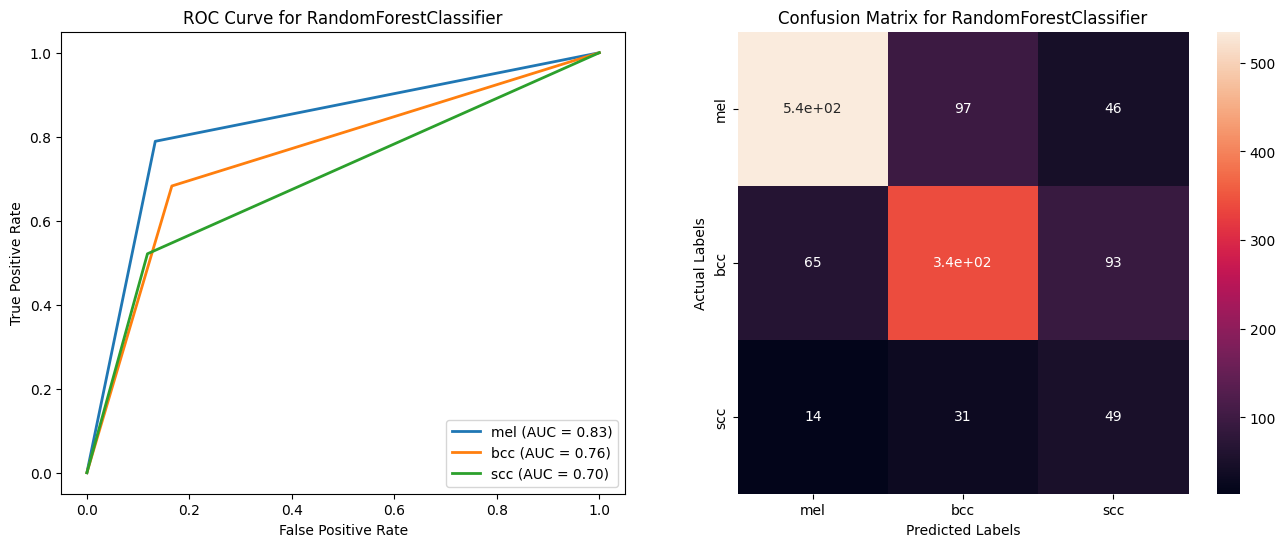

In [21]:
grid = {'n_estimators' : [50, 100, 200], 'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
model = RandomForestClassifier(class_weight='balanced')
model_fit_predict(model, grid, 'accuracy', X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded)

##### XGBoost

(   {   'accuracy': 0.8267716535433071,
        'balanced_accuracy': 0.7250774263816075,
        'bcc_f1': 0.815968841285297,
        'bcc_precision': 0.7920604914933838,
        'bcc_roc_auc': 0.8494392076076326,
        'bcc_sensitivity': 0.8413654618473896,
        'bcc_specificity': 0.8575129533678757,
        'best_params': {   'colsample_bytree': 1.0,
                           'learning_rate': 0.1,
                           'max_depth': 5,
                           'n_estimators': 300,
                           'subsample': 0.7},
        'kappa': 0.6882100085256819,
        'mel_f1': 0.8794007490636705,
        'mel_precision': 0.893455098934551,
        'mel_roc_auc': 0.8737692338356057,
        'mel_sensitivity': 0.8657817109144543,
        'mel_specificity': 0.8817567567567568,
        'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stop

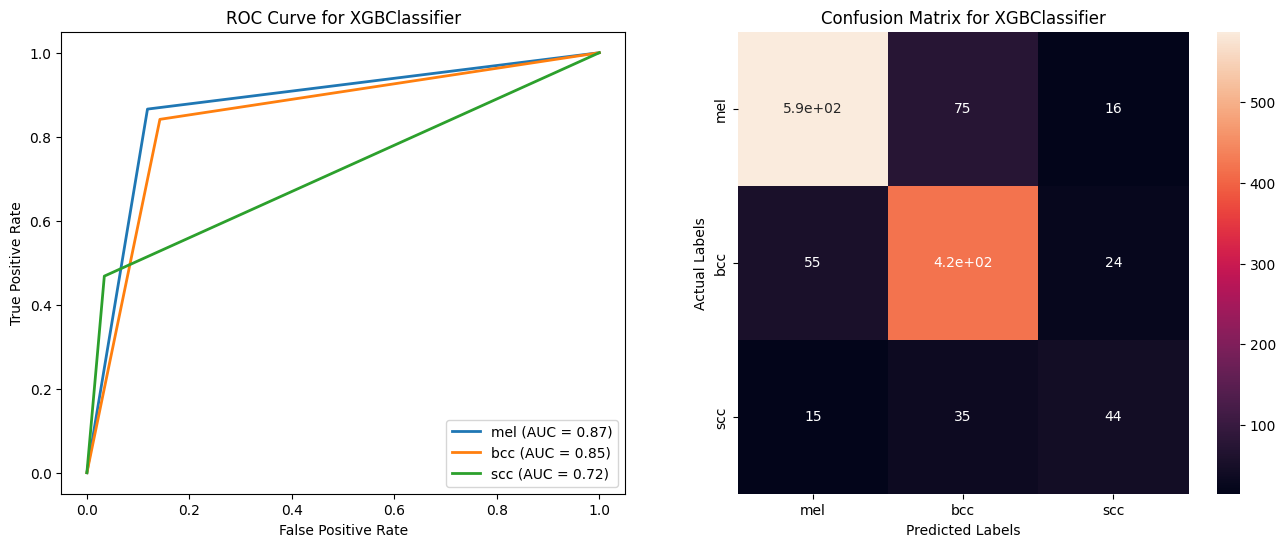

In [22]:
model = XGBClassifier({"device": "cuda:0" if gpu else "cpu"})
# grid = {'max_depth': [4, 5], 'learning_rate': [0.1, 0.01], 'n_estimators': [200, 300], 'subsample': [0.5, 0.7, 1.0], 'colsample_bytree': [0.8, 0.9, 1.0]}
grid = {'max_depth': [5], 'learning_rate': [0.1], 'n_estimators': [300], 'subsample': [0.7], 'colsample_bytree': [1.0]}

model_fit_predict(model, grid, 'accuracy', X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded)

##### Logistic Regression

(   {   'accuracy': 0.7181102362204724,
        'balanced_accuracy': 0.6655291220741876,
        'bcc_f1': 0.6865342163355408,
        'bcc_precision': 0.7622549019607843,
        'bcc_roc_auc': 0.7494251617870445,
        'bcc_sensitivity': 0.6244979919678715,
        'bcc_specificity': 0.8743523316062176,
        'best_params': {'C': 0.1, 'penalty': None, 'solver': 'newton-cholesky'},
        'kappa': 0.5302012035843005,
        'mel_f1': 0.845679012345679,
        'mel_precision': 0.8867313915857605,
        'mel_roc_auc': 0.8450081718887029,
        'mel_sensitivity': 0.8082595870206489,
        'mel_specificity': 0.8817567567567568,
        'model': LogisticRegression(C=0.1, class_weight='balanced', multi_class='ovr',
                   penalty=None, solver='newton-cholesky'),
        'scc_f1': 0.3136094674556213,
        'scc_precision': 0.21721311475409835,
        'scc_roc_auc': 0.7007074106238239,
        'scc_sensitivity': 0.5638297872340425,
        'scc_specificity': 0.8375

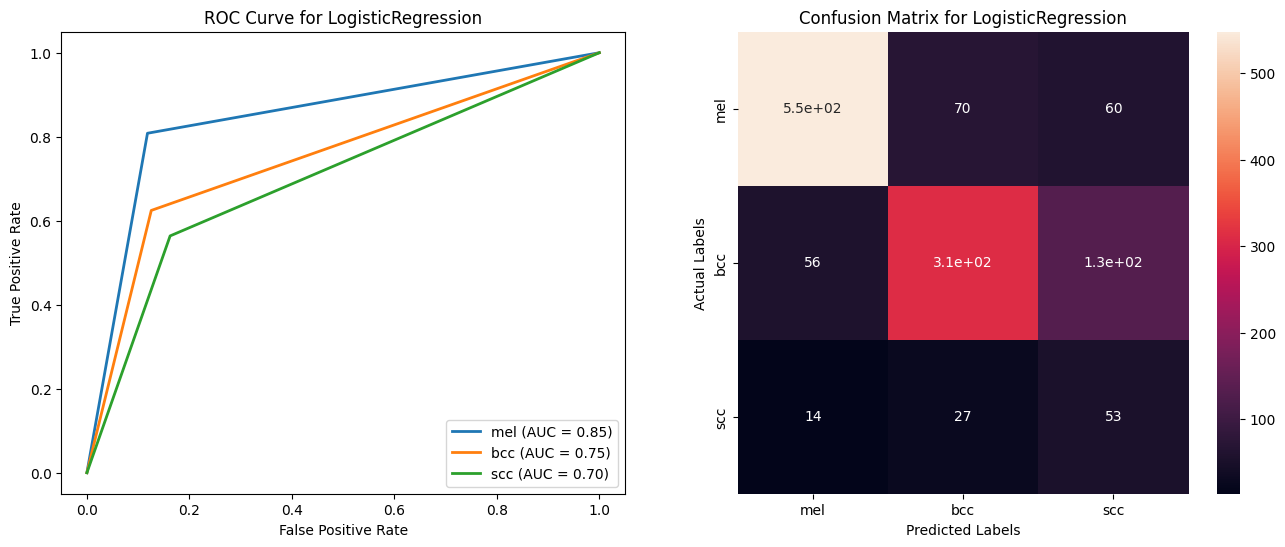

In [23]:
model = LogisticRegression(multi_class = 'ovr', class_weight='balanced')
grid = {'penalty' : ['l1', 'l2', 'elasticnet', None], 'C':[0.1, 1, 10], 'solver': ['lbfgs', 'newton-cholesky', 'sag', 'saga']}
model_fit_predict(model, grid, 'accuracy', X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded)

##### Ensemble VotingClassifier with the best models

(   {   'accuracy': 0.8456692913385827,
        'balanced_accuracy': 0.7530376322335726,
        'bcc_f1': 0.830558276199804,
        'bcc_precision': 0.8107074569789675,
        'bcc_roc_auc': 0.8615836402605239,
        'bcc_sensitivity': 0.8514056224899599,
        'bcc_specificity': 0.8717616580310881,
        'kappa': 0.7217066986266452,
        'mel_f1': 0.8956780923994038,
        'mel_precision': 0.9051204819277109,
        'mel_roc_auc': 0.8900058797735789,
        'mel_sensitivity': 0.8864306784660767,
        'mel_specificity': 0.893581081081081,
        'scc_f1': 0.5536723163841809,
        'scc_precision': 0.5903614457831325,
        'scc_roc_auc': 0.7461825155594154,
        'scc_sensitivity': 0.5212765957446809,
        'scc_specificity': 0.9710884353741497,
        'weighted_f1': 0.8448291070349694},)
(   array([[601,  65,  12],
       [ 52, 424,  22],
       [ 11,  34,  49]], dtype=int64),)


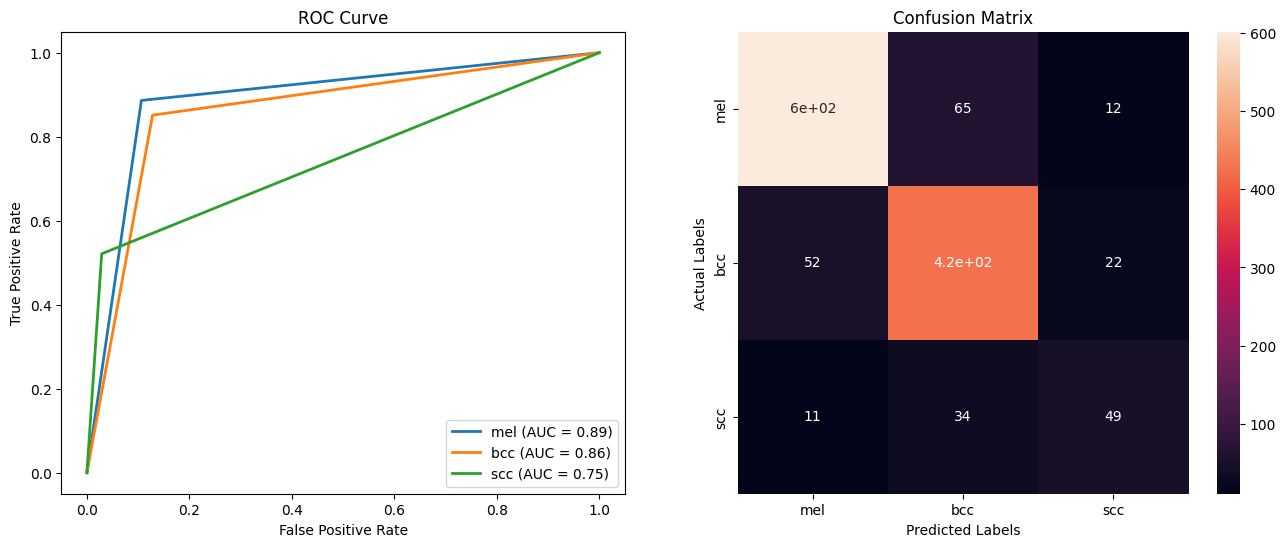

In [27]:
# Define the base classifiers
clf1 = SVC(C= 10, gamma=0.01, kernel='rbf', probability=True)  # Set probability=True for soft voting
clf2 = RandomForestClassifier(class_weight='balanced', max_depth= 9, min_samples_leaf=1, min_samples_split=5, n_estimators=200)
clf3 = XGBClassifier(colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.7)

# Create a VotingClassifier with soft voting
voting_clf = VotingClassifier(estimators=[('svc', clf1), ('rf', clf2), ('xgb', clf3)], voting='soft')

# Train the VotingClassifier on your training data
voting_clf.fit(X_train_normalized, y_train_encoded)

# Make predictions
y_pred = voting_clf.predict(X_val_normalized)

model_predict(y_pred, y_val_encoded)

#### 6.3 Undersampling with TomekLinks, oversampling with ADASYN, SelectKBest for feature selection

In [34]:
# Separate the data from the target in the train and validation sets
X_train = train_features.iloc[:,:-1]
y_train = train_features.iloc[:,-1]
X_val = val_features.iloc[:,:-1]
y_val = val_features.iloc[:,-1]

# Encoding the label column
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

# Print the distribution of the data
print(pd.DataFrame(y_train_encoded).value_counts())

0    2713
1    1993
2     376
Name: count, dtype: int64


In [35]:
# UNDERSAMPLING MAJORITY CLASS
undersampler = TomekLinks(sampling_strategy='majority')
X_train, y_train_encoded = undersampler.fit_resample(X_train, y_train_encoded)
print(pd.DataFrame(y_train_encoded).value_counts())

# OVERSAMPLING MINORITY CLASS WITH ADASYN
adasyn = ADASYN(sampling_strategy='minority', random_state=0) 
X_train, y_train_encoded = adasyn.fit_resample(X_train, y_train_encoded)
print(pd.DataFrame(y_train_encoded).value_counts())

0    2531
1    1993
2     376
Name: count, dtype: int64
2    2578
0    2531
1    1993
Name: count, dtype: int64


In [36]:
# Standardizing the training data (mean = 0, std = 1)
scaler = StandardScaler()
X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train))
X_val_normalized = pd.DataFrame(scaler.transform(X_val))

# Feature selection using select k best
X_train_normalized, selected_feature_indices  = select_feature.select_bestk_features(X_train_normalized, y_train_encoded)

# Apply the same transformation to the validation set
X_val_normalized = X_val_normalized.iloc[:, selected_feature_indices]

##### SVM

(   {   'accuracy': 0.8275590551181102,
        'balanced_accuracy': 0.7608009392745778,
        'bcc_f1': 0.8050930460333007,
        'bcc_precision': 0.7858508604206501,
        'bcc_roc_auc': 0.8401117423060117,
        'bcc_sensitivity': 0.8253012048192772,
        'bcc_specificity': 0.8549222797927462,
        'best_params': {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
        'kappa': 0.6934531026121459,
        'mel_f1': 0.8848484848484849,
        'mel_precision': 0.9096573208722741,
        'mel_roc_auc': 0.8816919795902097,
        'mel_sensitivity': 0.8613569321533924,
        'mel_specificity': 0.902027027027027,
        'model': SVC(C=10, class_weight='balanced', gamma=0.01),
        'scc_f1': 0.5628140703517588,
        'scc_precision': 0.5333333333333333,
        'scc_roc_auc': 0.7770390070921986,
        'scc_sensitivity': 0.5957446808510638,
        'scc_specificity': 0.9583333333333334,
        'weighted_f1': 0.8297386868227731},)
(   array([[584,  83,  11],
       [ 49

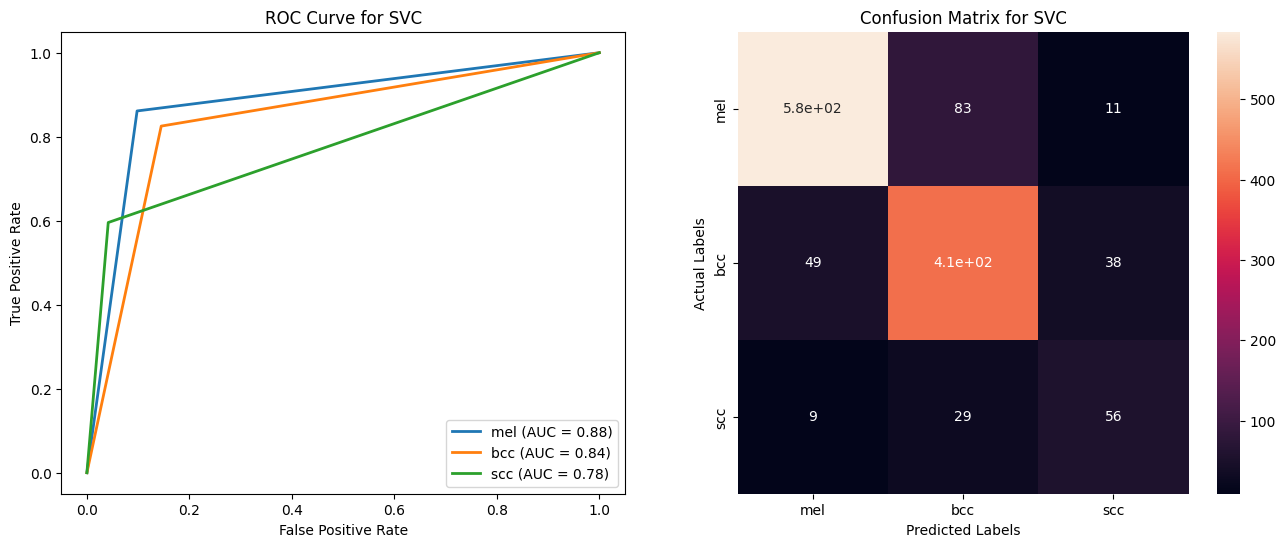

In [24]:
grid = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10], 'gamma':[0.001, 0.01, 0.1]}
model = SVC(decision_function_shape='ovr', class_weight='balanced')
model_fit_predict(model, grid, 'accuracy', X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded)

##### Random Forests

(   {   'accuracy': 0.7094488188976378,
        'balanced_accuracy': 0.6557891643143212,
        'bcc_f1': 0.6837060702875399,
        'bcc_precision': 0.7278911564625851,
        'bcc_roc_auc': 0.7445689493726201,
        'bcc_sensitivity': 0.6445783132530121,
        'bcc_specificity': 0.844559585492228,
        'best_params': {   'max_depth': 9,
                           'min_samples_leaf': 1,
                           'min_samples_split': 2,
                           'n_estimators': 200},
        'kappa': 0.5134675520450496,
        'mel_f1': 0.8259172521467604,
        'mel_precision': 0.8772802653399668,
        'mel_roc_auc': 0.8276179941002949,
        'mel_sensitivity': 0.7802359882005899,
        'mel_specificity': 0.875,
        'model': RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=200),
        'scc_f1': 0.31875,
        'scc_precision': 0.22566371681415928,
        'scc_roc_auc': 0.6968718338399189,
        'scc_sensitivity': 0.5425531914893

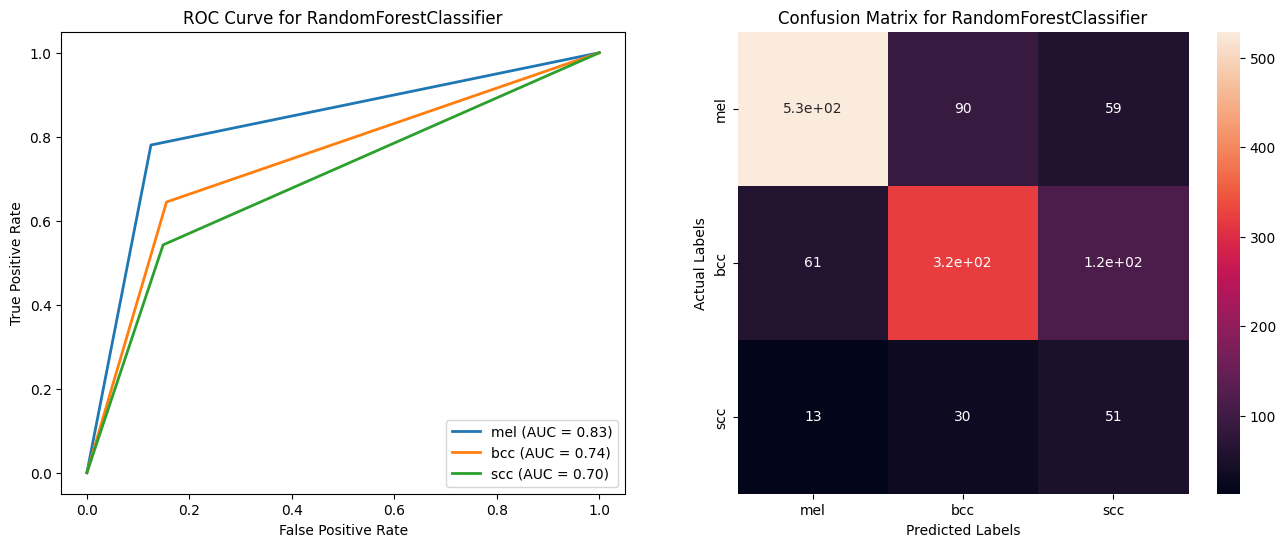

In [25]:
grid = {'n_estimators' : [50, 100, 200], 'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
model = RandomForestClassifier(class_weight='balanced')
model_fit_predict(model, grid, 'accuracy', X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded)

##### XGBoost

(   {   'accuracy': 0.8078740157480315,
        'balanced_accuracy': 0.7255293690925128,
        'bcc_f1': 0.796828543111992,
        'bcc_precision': 0.786692759295499,
        'bcc_roc_auc': 0.8330186029090455,
        'bcc_sensitivity': 0.8072289156626506,
        'bcc_specificity': 0.8588082901554405,
        'best_params': {   'colsample_bytree': 1.0,
                           'learning_rate': 0.1,
                           'max_depth': 5,
                           'n_estimators': 300,
                           'subsample': 0.7},
        'kappa': 0.6598388548596017,
        'mel_f1': 0.869894099848714,
        'mel_precision': 0.8928571428571429,
        'mel_roc_auc': 0.8657642709080763,
        'mel_sensitivity': 0.8480825958702065,
        'mel_specificity': 0.8834459459459459,
        'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopp

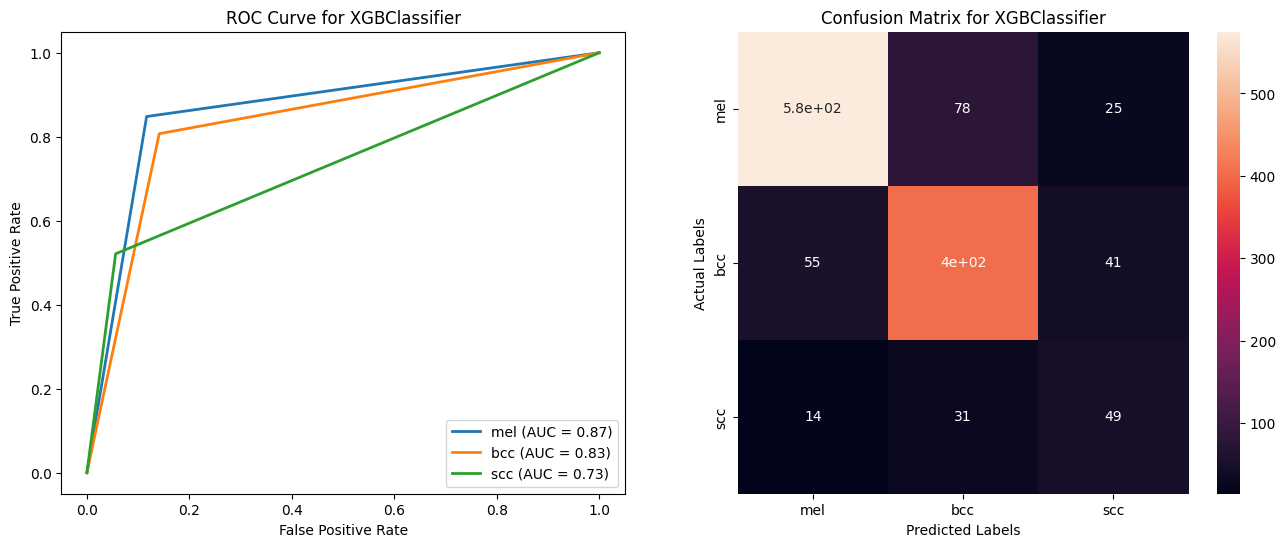

In [37]:
model = XGBClassifier({"device": "cuda:0" if gpu else "cpu"})
# grid = {'max_depth': [4, 5], 'learning_rate': [0.1, 0.01], 'n_estimators': [200, 300], 'subsample': [0.5, 0.7, 1.0], 'colsample_bytree': [0.8, 0.9, 1.0]}
grid = {'max_depth': [5], 'learning_rate': [0.1], 'n_estimators': [300], 'subsample': [0.7], 'colsample_bytree': [1.0]}

model_fit_predict(model, grid, 'accuracy', X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded)

##### Logistic Regression

(   {   'accuracy': 0.7,
        'balanced_accuracy': 0.6431032609695672,
        'bcc_f1': 0.672645739910314,
        'bcc_precision': 0.7614213197969543,
        'bcc_roc_auc': 0.7403239902615644,
        'bcc_sensitivity': 0.6024096385542169,
        'bcc_specificity': 0.8782383419689119,
        'best_params': {'C': 1, 'penalty': 'l2', 'solver': 'newton-cholesky'},
        'kappa': 0.5058880474474916,
        'mel_f1': 0.8382581648522551,
        'mel_precision': 0.8865131578947368,
        'mel_roc_auc': 0.8392155983417046,
        'mel_sensitivity': 0.7949852507374632,
        'mel_specificity': 0.8834459459459459,
        'model': LogisticRegression(C=1, class_weight='balanced', multi_class='ovr',
                   solver='newton-cholesky'),
        'scc_f1': 0.27624309392265195,
        'scc_precision': 0.1865671641791045,
        'scc_roc_auc': 0.6732703719785786,
        'scc_sensitivity': 0.5319148936170213,
        'scc_specificity': 0.814625850340136,
        'weighted_f1

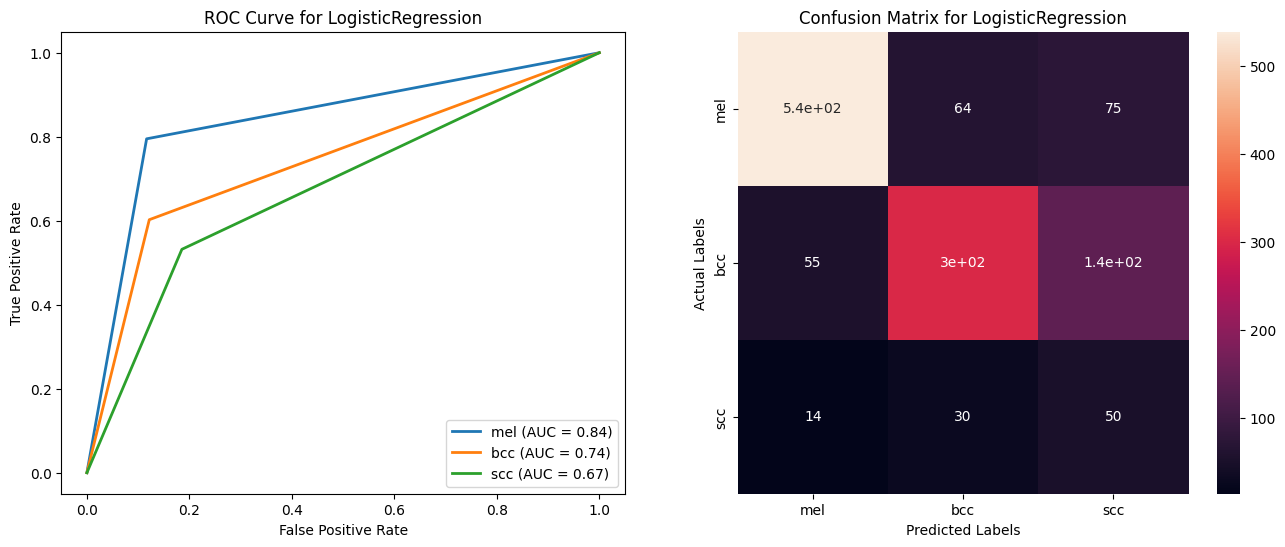

In [26]:
model = LogisticRegression(multi_class = 'ovr', class_weight='balanced')
grid = {'penalty' : ['l1', 'l2', 'elasticnet', None], 'C':[0.1, 1, 10], 'solver': ['lbfgs', 'newton-cholesky', 'sag', 'saga']}
model_fit_predict(model, grid, 'accuracy', X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded)

##### Ensemble VotingClassifier with the best models

(   {   'accuracy': 0.8346456692913385,
        'balanced_accuracy': 0.7420339740938271,
        'bcc_f1': 0.8180039138943249,
        'bcc_precision': 0.7977099236641222,
        'bcc_roc_auc': 0.851025865118505,
        'bcc_sensitivity': 0.8393574297188755,
        'bcc_specificity': 0.8626943005181347,
        'kappa': 0.7020830726886025,
        'mel_f1': 0.8865671641791044,
        'mel_precision': 0.8972809667673716,
        'mel_roc_auc': 0.8806206649127003,
        'mel_sensitivity': 0.8761061946902655,
        'mel_specificity': 0.8851351351351351,
        'scc_f1': 0.5393258426966292,
        'scc_precision': 0.5714285714285714,
        'scc_roc_auc': 0.7400130264871905,
        'scc_sensitivity': 0.5106382978723404,
        'scc_specificity': 0.9693877551020408,
        'weighted_f1': 0.8339804060207006},)
(   array([[594,  73,  11],
       [ 55, 418,  25],
       [ 13,  33,  48]], dtype=int64),)


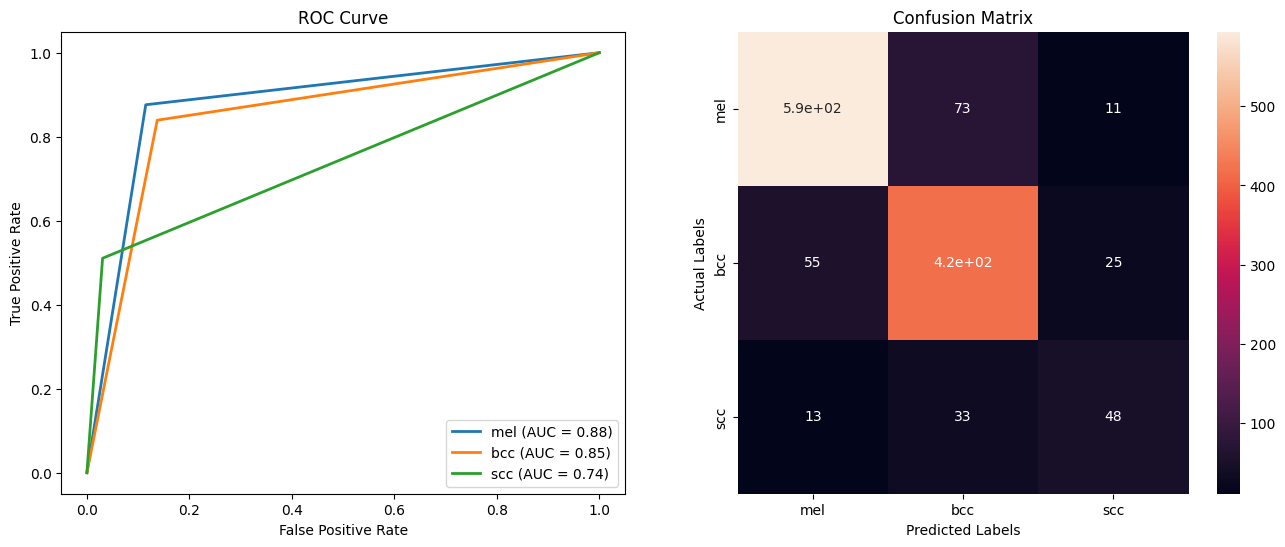

In [38]:
# Define the base classifiers
clf1 = SVC(C= 10, gamma=0.01, kernel='rbf', probability=True)  # Set probability=True for soft voting
clf2 = RandomForestClassifier(class_weight='balanced', max_depth= 9, min_samples_leaf=1, min_samples_split=2, n_estimators=200)
clf3 = XGBClassifier(colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.7)

# Create a VotingClassifier with soft voting
voting_clf = VotingClassifier(estimators=[('svc', clf1), ('rf', clf2), ('xgb', clf3)], voting='soft')

# Train the VotingClassifier on your training data
voting_clf.fit(X_train_normalized, y_train_encoded)

# Make predictions
y_pred = voting_clf.predict(X_val_normalized)

model_predict(y_pred, y_val_encoded)

#### 7. Retraining the best model with all the data and predicting on the testing set

Best model pipeline: SMOTE for oversampling, RandomUndersampling + RFE for feature selection
Classifier: soft voting ensemble using SVM, Random Forests and XGBoost

Preprocessing and feature extraction of the test set

In [30]:
ROOT_PATH = Path(Path(os.getcwd())/"../challenge2")
TEST_PATH = ROOT_PATH/"testX/*"
testX    = sorted(glob(str(TEST_PATH)))

features_dir = r'../output/features/'
test_features_filename = 'test_features_mel_bcc_scc.csv'

subsample = False

with open(os.path.join(features_dir, test_features_filename), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    for index, filename in tqdm(enumerate(testX)):
        
            if subsample:
                if count == 999: # only 1k per class
                    break

            # reading the image 
            image = cv2.imread(filename,cv2.IMREAD_COLOR)

            # 1. Copping black frame
            image_without_black_frame, _ = preprocessor.crop_frame(image)

            # 2. Resizing
            image_resized = preprocessor.resize_images(image_without_black_frame, preserve_ratio=True)

            # 3. Removing hair
            image_without_hair = preprocessor.extract_hair(image_resized)

            # 4. Extracting features
            feature_vector = feature_extractor.fit(image_without_hair)

            # Write the feature vector to the CSV file
            writer.writerow(feature_vector)

0it [00:00, ?it/s]c:\master\udg\CAD\project\env\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
40it [02:42,  6.18s/it]C:\Users\lui_a\AppData\Local\Temp\ipykernel_5440\2862656740.py:129: RuntimeWarning: divide by zero encountered in scalar divide
  if mean_outside / mean_inside < threshold:
2121it [1:17:56,  2.20s/it]


Loading the test, validation and training sets

In [7]:
features_dir = r'../output/features/'
experiment              = 3

train_bcc_df = pd.read_csv(os.path.join(features_dir,f'{experiment}_bcc_train_features.csv'),  header = None)
val_bcc_df = pd.read_csv(os.path.join(features_dir, f'{experiment}_bcc_val_features.csv'),  header = None)

train_mel_df = pd.read_csv(os.path.join(features_dir,f'{experiment}_mel_train_features.csv'),  header = None)
val_mel_df = pd.read_csv(os.path.join(features_dir, f'{experiment}_mel_val_features.csv'),  header = None)

train_scc_df = pd.read_csv(os.path.join(features_dir,f'{experiment}_scc_train_features.csv'),  header = None)
val_scc_df = pd.read_csv(os.path.join(features_dir, f'{experiment}_scc_val_features.csv'),  header = None)

test_df = pd.read_csv(os.path.join(features_dir, 'test_features_mel_bcc_scc.csv'),  header = None)

In [8]:
print(f"Shape of training dataframe for mel class: {train_mel_df.shape}")
print(f"Shape of training dataframe for bcc class: {train_bcc_df.shape}")
print(f"Shape of training dataframe for scc class: {train_scc_df.shape}")
print(f"Shape of validation dataframe for mel class: {val_mel_df.shape}")
print(f"Shape of validation dataframe for bcc class: {val_bcc_df.shape}")
print(f"Shape of validation dataframe for scc class: {val_scc_df.shape}")
print(f"Shape of test dataframe: {test_df.shape}")

Shape of training dataframe for mel class: (2713, 279)
Shape of training dataframe for bcc class: (1993, 279)
Shape of training dataframe for scc class: (376, 279)
Shape of validation dataframe for mel class: (678, 279)
Shape of validation dataframe for bcc class: (498, 279)
Shape of validation dataframe for scc class: (94, 279)
Shape of test dataframe: (2121, 278)


Concatenating the training and validation set to train the final model

In [9]:
# Concatenate all the dataframes together (both train and validation set)
train_features = pd.concat([train_bcc_df, train_mel_df, train_scc_df, val_bcc_df, val_mel_df, val_scc_df])
train_features = train_features.sample(frac=1, random_state=42)

X_train = train_features.iloc[:,:-1]
y_train = train_features.iloc[:,-1]

X_test = test_df

# Encoding the label column
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)

# Print the distribution of de data
print(pd.DataFrame(y_train_encoded).value_counts())

0    3391
1    2491
2     470
Name: count, dtype: int64


In [10]:
# OVERSAMPLING WITH SMOTE
smote = SMOTE(sampling_strategy={0:3391,1:2491,2:2491}, random_state=0) 
X_train, y_train_encoded = smote.fit_resample(X_train, y_train_encoded)

# RANDOM UNDERSAMPLING
undersampler = RandomUnderSampler(sampling_strategy={0:2875,1:2491,2:2491}, random_state=0)
X_train, y_train_encoded = undersampler.fit_resample(X_train, y_train_encoded)

# Print the new distribution of data
print(pd.DataFrame(y_train_encoded).value_counts())

0    2875
1    2491
2    2491
Name: count, dtype: int64


In [11]:
X_train.shape

(7857, 278)

In [12]:
# Standardizing the training data (mean = 0, std = 1)
scaler = StandardScaler()
X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train))
X_test_normalized = pd.DataFrame(scaler.transform(X_test))

# Feature selection using RFE
X_train_normalized, selected_feature_indices  = select_feature.select_rfe_features(X_train_normalized, y_train_encoded)

# Apply the same transformation to the test set
X_test_normalized = X_test_normalized.iloc[:, selected_feature_indices]

Fitting estimator with 278 features.
Fitting estimator with 277 features.
Fitting estimator with 276 features.
Fitting estimator with 275 features.
Fitting estimator with 274 features.
Fitting estimator with 273 features.
Fitting estimator with 272 features.
Fitting estimator with 271 features.
Fitting estimator with 270 features.
Fitting estimator with 269 features.
Fitting estimator with 268 features.
Fitting estimator with 267 features.
Fitting estimator with 266 features.
Fitting estimator with 265 features.
Fitting estimator with 264 features.
Fitting estimator with 263 features.
Fitting estimator with 262 features.
Fitting estimator with 261 features.
Fitting estimator with 260 features.
Fitting estimator with 259 features.
Fitting estimator with 258 features.
Fitting estimator with 257 features.
Fitting estimator with 256 features.
Fitting estimator with 255 features.
Fitting estimator with 254 features.
Fitting estimator with 253 features.
Fitting estimator with 252 features.
F

In [13]:
selected_feature_indices

array([  0,  17,  36,  44,  45,  46,  49,  50,  51,  54,  56,  57,  66,
        70,  72,  73,  74,  75,  77,  80,  82,  83,  84,  85,  87,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98, 101, 103, 105, 107,
       108, 109, 110, 112, 114, 115, 116, 117, 118, 119, 121, 122, 123,
       124, 125, 126, 127, 128, 130, 131, 133, 135, 136, 137, 138, 139,
       148, 150, 157, 161, 162, 163, 165, 166, 173, 189, 190, 191, 193,
       194, 198, 200, 201, 206, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 224, 226, 227, 228, 229, 230, 232, 234, 235,
       236, 238, 239, 240, 241, 242, 243, 244, 246, 247, 248, 249, 250,
       251, 253, 259, 260, 261, 270, 271, 272, 274], dtype=int64)

In [14]:
X_train_normalized.shape

(7857, 126)

In [15]:
X_test_normalized.shape

(2121, 126)

Train the final ensemble model with all the data

In [ ]:
# Define the base classifiers
clf1 = SVC(C= 10, gamma=0.01, kernel='rbf', probability=True)  # Set probability=True for soft voting
clf2 = RandomForestClassifier(class_weight='balanced', max_depth= 9, min_samples_leaf=1, min_samples_split=2, n_estimators=200)
clf3 = XGBClassifier(colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.7)

# Create a VotingClassifier with soft voting
voting_clf = VotingClassifier(estimators=[('svc', clf1), ('rf', clf2), ('xgb', clf3)], voting='soft')

# Train the VotingClassifier on your training data
voting_clf.fit(X_train_normalized, y_train_encoded)

Save the final trained model in a file

In [ ]:
# Save the VotingClassifier model to a file
import joblib
joblib.dump(voting_clf, '../output/final_model_challenge2.pkl')

Predict on the test set and save the predictions in a .csv file

In [ ]:
# Predig on the test set
y_pred = voting_clf.predict(X_test_normalized)

# Create a DataFrame with the predictions
df_test = pd.DataFrame({'Predictions': y_pred})

# Save the DataFrame to an Excel file
df_test.to_excel('../output/challenge1_predictions.xlsx', header=False, index=False)